In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

def sinc_interp(u, s, x):
    """
    Interpolates x, sampled at "s" instants
    Output y is sampled at "u" instants ("u" for "upsampled")
    
    from Matlab:
    http://phaseportrait.blogspot.com/2008/06/sinc-interpolation-in-matlab.html        
    """

    
    # Find the period    
    T = s[1] - s[0]
    
    sincM = np.tile(u, (len(s), 1)) - np.tile(s[:, np.newaxis], (1, len(u)))
    y = np.dot(x, np.sinc(sincM/T))
    return y

def fourier_plot(X,U,S1,K,Uh,S2):
    fig,ax = plt.subplots(1,2)

    for i in range(len(X)):
        ax[0].plot(X[i],U[i],S1[i])
    ax[0].set_xlabel(r'$x$')
    ax[0].set_title('signal $u(x)$')

    for i in range(len(K)):
        ax[1].plot(K[i],Uh[i],S2[i])
    ax[1].set_xlim([0,10])
    ax[1].set_xlabel(r'$k$')
    ax[1].set_title('spectrum $|\widehat{u}(k)|$')

    fig.tight_layout()
    fig.set_figwidth(10)

# Compressed sensing

## Nyquist sampling

> A signal with bandwidth $B$ can be reconstructed by sampling it with a rate of $2B$.

* In practice this means that we can reconstruct the signal perfectly from samples $u_i = u(i\cdot \Delta x)$, with $\Delta t \leq 1/(2B)$, using Sinc interpolation: $$u(x) = \sum_i u_i \text{sinc}\left(\frac{x - i\cdot\Delta x}{\Delta x}\right).$$
* Violating the sampling criterion results in aliasing

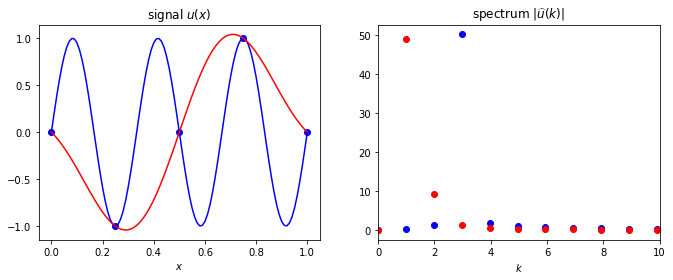

In [4]:
n = 101
x = np.linspace(0,1,n)
k = np.fft.rfftfreq(n, d = 1/(n-1))

m = 5
xm = np.linspace(0,1,m)

u = lambda x : np.sin(6*np.pi*x)

un = u(x)
um = u(xm)
ui = sinc_interp(x,xm,um)
    
fourier_plot([x,xm,x],[un,um,ui],['b','bo','r'],[k,k],[np.abs(np.fft.rfft(un)),np.abs(np.fft.rfft(ui))],['bo','ro'])

## Signal reconstruction

Sampling

$$f = Su,$$

Fourier transform

$$\widehat{u} = Fu.$$

* Can we reconstruct $\widehat{u}$ from $f$ by solving $$f = SF^*\widehat{u}.$$
* Linear algebra dictates that when given $m$ measurements, we can only reconstruct $n \leq m$ unknowns.
* With a unit sampling interval, this means we need to sample $u$ at $n$ points to reconstruct $\widehat{u}$ at frequencies $\{0, 1, 2, \ldots, n/2\}$.
* Using less samples typically results in aliasing artefacts

## Irregular (sub) sampling

* Consider taking samples at random locations, does this avoid aliasing?

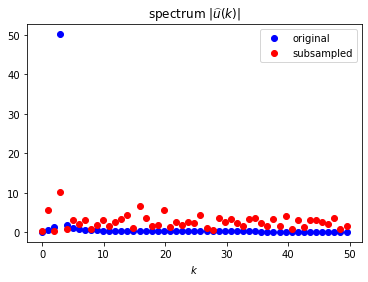

In [16]:
n = 101
x = np.linspace(0,1,n)
k = np.fft.rfftfreq(n, d = 1/(n-1))

m = 30
idx = np.random.randint(0,n,m)
xm = x[idx]

u = lambda x : np.sin(6*np.pi*x)

un = u(x)
um = u(xm)

ui = np.zeros(n)
ui[idx] = um
    
plt.plot(k,np.abs(np.fft.rfft(un)),'bo',k,np.abs(np.fft.rfft(ui)),'ro')
plt.xlabel('$k$')
plt.title('spectrum $|\widehat{u}(k)|$')
plt.legend(['original','subsampled'])
#fourier_plot([x,xm,x],[un,um,ui],['b','bo','r'],[k,k],[np.abs(np.fft.rfft(un)),np.abs(np.fft.rfft(ui))],['bo','ro'])

## Compressed sensing

Considering an underdetermined system of equations $$Ku = f,$$ with $K \in \mathbb{R}^{m\times n}$.

* If the system allows a sparse solution with $k < \text{spark}(A)/2$ elements, it is necessarily the sparsest one

* $\text{spark}(A)$ is the smallest number of columns of $A$ that are linearly dependent

* If $K$ is a random Gaussian matrix, no columns are linearly dependent, hence $\text{spark}(K) = m+1$.

* This implies that we can reconstruct a sparse signal with $m/2$ elements from $m$ measurements, regardless of the ambient dimension $n$.

* Finding the sparsest solution to a systems of equations is a difficult problem to solve.

We can instead solve a relaxed problem $$\min_{u} \|u\|_1\quad\text{s.t.}\quad Ku = f,$$

* If this yields a $k-$sparse solution and $K \in RIP(.41,2k)$, then the solution is the sparsest one possible

* $K \in RIP(\epsilon,2k)$ means that $$(1-\epsilon)\|u\|_2 \leq \|Ku\|_2 \leq (1+\epsilon)\|u\|_2,$$
for all $2k-$sparse vectors $u$.

* If $K$ is a random Gaussian matrix, it statisfies this property if $k < c (1 + \log(n/m))m$.
* In practice, if $m > 2 \log(n/m)k$ the vector is highly likely to be recovered by $\ell_1$ minimization.
* Compared to $m \geq n$ in general

These results generalise to noisy data

$$\min_{u} \|u\|_1\quad\text{s.t.}\quad \|Ku - f^\delta\|_2\leq\delta,$$

* We can solve this via $$\min_u \|Ku - f^\delta\|_2^2 + \lambda \|u\|_1.$$

## Further reading
* http://www.geintra-uah.org/system/files/review_paper_siam_review.pdf

## Assignment

* Investigate how solving the Lasso problem recovers a $k$-sparse vector in $\mathbb{R}^n$ from $m$ random Gaussian measurements; is it indeed possible for $m > 2 \log(n/m)k$?
* A usefull tool for this is a so-called phase diagram, which plots the recovery probability as a function of $k$ and $m$ for fixed $n$.

residual =  0.08041259858612541
error =  0.2211304724797784


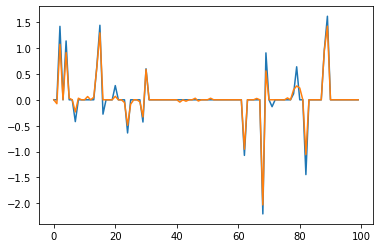

In [17]:
m = 50
n = 100
k = 20

# random matrix
K = np.random.randn(m,n)

# k-sparse vector
idx = np.random.randint(0,n,k)
u = np.zeros(n)
u[idx] = np.random.randn(k)

# data
f = K@u

# solve LASSO
alpha = .05
clf = linear_model.Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
clf.fit(K,f)
u_rec = clf.coef_

# error
print('residual = ', np.linalg.norm(K@u_rec - f)/np.linalg.norm(f))
print('error = ', np.linalg.norm(u-u_rec)/np.linalg.norm(u))

# plot
plt.plot(u)
plt.plot(u_rec)

In [19]:
def experiment(m,n,k,alpha=0.1):
    # random matrix
    K = np.random.randn(m,n)

    # k-sparse vector
    idx = np.random.randint(0,n,k)
    u = np.zeros(n)
    u[idx] = np.random.randn(k)

    # data
    f = K@u

    # solve LASSO
    clf = linear_model.Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
    clf.fit(K,f)
    u_rec = clf.coef_
    
    #
    return np.linalg.norm(u-u_rec)/np.linalg.norm(u)


n = 20
ns = 20

P = np.zeros((n,n,ns))
for m in range(1,n):
    for k in range(1,n):
        for i in range(ns):
            error = experiment(m,n,k,alpha=0.001)
            P[m,k,i] = error

/opt/anaconda3/envs/astra/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


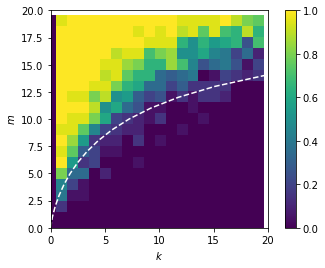

In [20]:
S = np.zeros((n,n))
for m in range(1,n):
    for k in range(1,n):
        S[m,k] = np.mean(P[m,k,:]<=.1)
        
ms = np.array(range(n))
ks = np.array(range(n))

plt.imshow(S,origin='lower')
plt.plot(ms/(2*np.log(n/ms)),ks,'w--')
plt.xlim([0,n])
plt.ylim([0,n])
plt.xlabel('$k$')
plt.ylabel('$m$')
plt.colorbar()